# Changes from v1: 
#####  1. Switched to LeakyReLU (from ReLU) on generator. 

# Changes from v2: 
#####  1. Trained Discriminator only if Loss_d > Threshold. 

In [1]:
import os

DATA_DIR = 'C:/Users/yigii/OneDrive/Masaüstü/python_projects/portfolioprojects/gan/animefaces/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

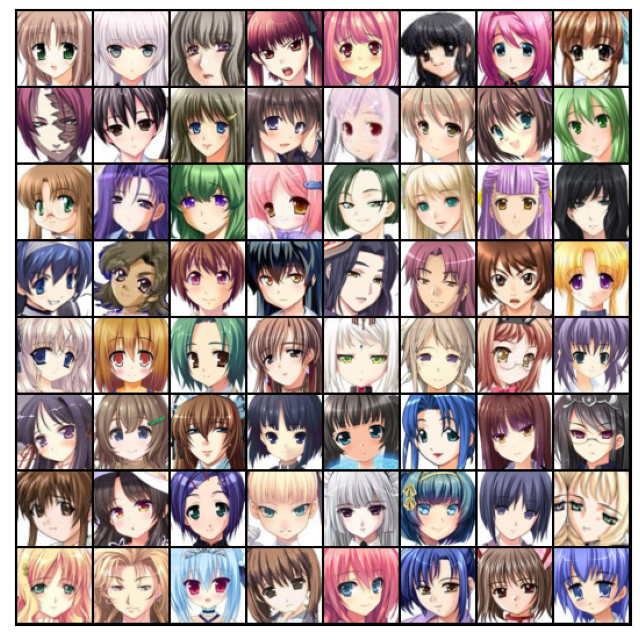

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


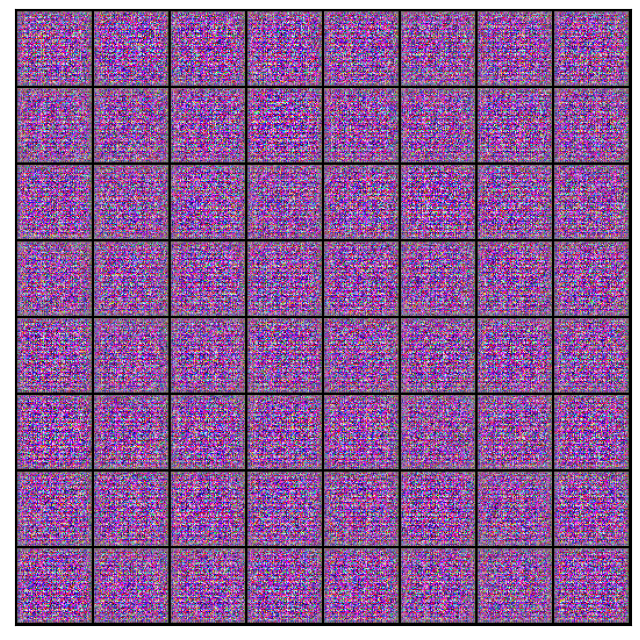

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d, d_loss_threshold=0.2):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights only if loss is greater than threshold
    loss = real_loss + fake_loss
    if loss > d_loss_threshold:
        loss.backward()
        opt_d.step()

    return loss.item(), real_score, fake_score


In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


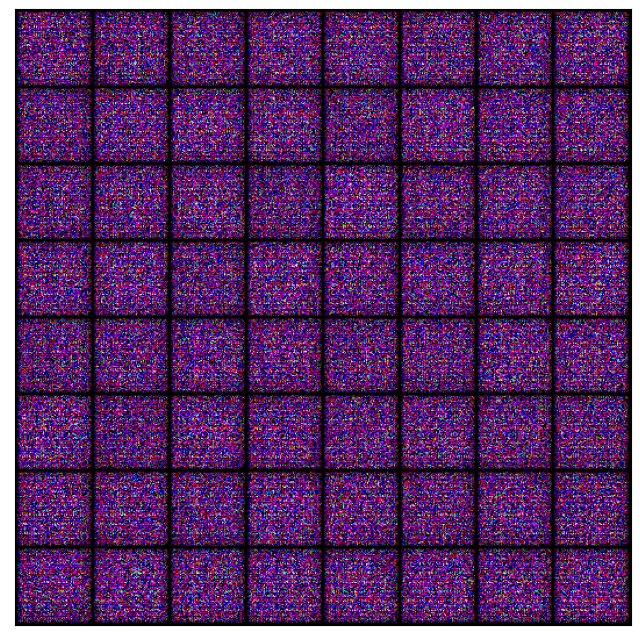

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 50

In [29]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.9348, loss_d: 0.5710, real_score: 0.6401, fake_score: 0.0537
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.2981, loss_d: 0.4874, real_score: 0.6900, fake_score: 0.0367
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.9643, loss_d: 0.3285, real_score: 0.9234, fake_score: 0.1981
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 4.0684, loss_d: 1.3074, real_score: 0.3393, fake_score: 0.0009
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.0820, loss_d: 0.3842, real_score: 0.8521, fake_score: 0.1693
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.9013, loss_d: 0.2105, real_score: 0.9601, fake_score: 0.1368
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.2062, loss_d: 0.2211, real_score: 0.8699, fake_score: 0.0657
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.7278, loss_d: 0.2159, real_score: 0.8440, fake_score: 0.0203
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.1444, loss_d: 0.2023, real_score: 0.8483, fake_score: 0.0239
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.3631, loss_d: 0.1627, real_score: 0.9683, fake_score: 0.1155
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.9255, loss_d: 0.3371, real_score: 0.9007, fake_score: 0.1896
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.4068, loss_d: 0.2326, real_score: 0.8484, fake_score: 0.0452
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.4929, loss_d: 0.1824, real_score: 0.9645, fake_score: 0.1261
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 0.7927, loss_d: 0.7689, real_score: 0.5379, fake_score: 0.0122
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.8652, loss_d: 0.2411, real_score: 0.9823, fake_score: 0.1873
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.8461, loss_d: 0.1660, real_score: 0.9599, fake_score: 0.1098
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.6786, loss_d: 0.0872, real_score: 0.9361, fake_score: 0.0157
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.5070, loss_d: 0.1475, real_score: 0.8859, fake_score: 0.0184
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.6719, loss_d: 0.1591, real_score: 0.8978, fake_score: 0.0402
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.2701, loss_d: 0.2282, real_score: 0.9236, fake_score: 0.1244
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.7503, loss_d: 0.2039, real_score: 0.8964, fake_score: 0.0746
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 8.5224, loss_d: 0.3372, real_score: 0.9735, fake_score: 0.2293
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 1.9245, loss_d: 0.1920, real_score: 0.9719, fake_score: 0.1365
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.6216, loss_d: 0.2286, real_score: 0.8773, fake_score: 0.0800
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.7639, loss_d: 0.1925, real_score: 0.9072, fake_score: 0.0748
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.4586, loss_d: 0.1835, real_score: 0.9670, fake_score: 0.1240
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.9064, loss_d: 0.2305, real_score: 0.9952, fake_score: 0.1716
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.3282, loss_d: 0.1076, real_score: 0.9687, fake_score: 0.0685
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.1042, loss_d: 0.2669, real_score: 0.7980, fake_score: 0.0050
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.3519, loss_d: 0.0945, real_score: 0.9431, fake_score: 0.0287
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.1380, loss_d: 0.2345, real_score: 0.8231, fake_score: 0.0116
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.1815, loss_d: 0.3137, real_score: 0.7928, fake_score: 0.0401
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.8284, loss_d: 0.2318, real_score: 0.9415, fake_score: 0.1395
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.0017, loss_d: 0.1349, real_score: 0.9745, fake_score: 0.0949
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 5.3379, loss_d: 0.2163, real_score: 0.9608, fake_score: 0.1416
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.1848, loss_d: 0.1100, real_score: 0.9352, fake_score: 0.0357
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 2.9742, loss_d: 0.6070, real_score: 0.6137, fake_score: 0.0008
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 2.9788, loss_d: 0.1280, real_score: 0.9884, fake_score: 0.0973
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.0633, loss_d: 0.1603, real_score: 0.8786, fake_score: 0.0133
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 7.0444, loss_d: 0.3604, real_score: 0.9699, fake_score: 0.2429
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.3938, loss_d: 0.1793, real_score: 0.9857, fake_score: 0.1347
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.4869, loss_d: 0.1017, real_score: 0.9443, fake_score: 0.0352
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.9416, loss_d: 0.1939, real_score: 0.8746, fake_score: 0.0151
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.1954, loss_d: 0.1407, real_score: 0.9763, fake_score: 0.0954
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.2513, loss_d: 0.2509, real_score: 0.8260, fake_score: 0.0031
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.7702, loss_d: 0.1509, real_score: 0.9973, fake_score: 0.1188
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 6.3825, loss_d: 0.0914, real_score: 0.9425, fake_score: 0.0109
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 9.0247, loss_d: 0.2499, real_score: 0.8732, fake_score: 0.0586
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 8.3515, loss_d: 0.0346, real_score: 0.9734, fake_score: 0.0009
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.8080, loss_d: 0.1189, real_score: 0.9381, fake_score: 0.0189
Saving generated-images-0050.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

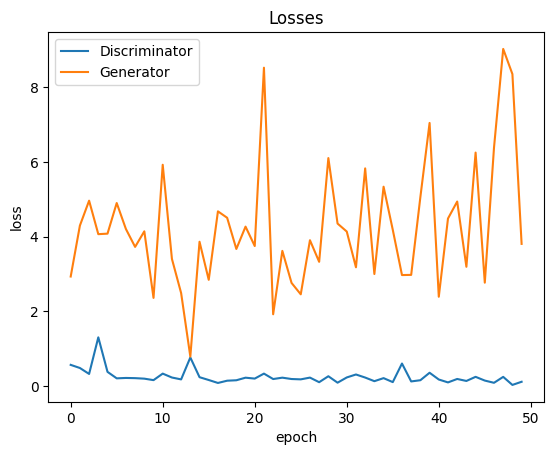

In [31]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

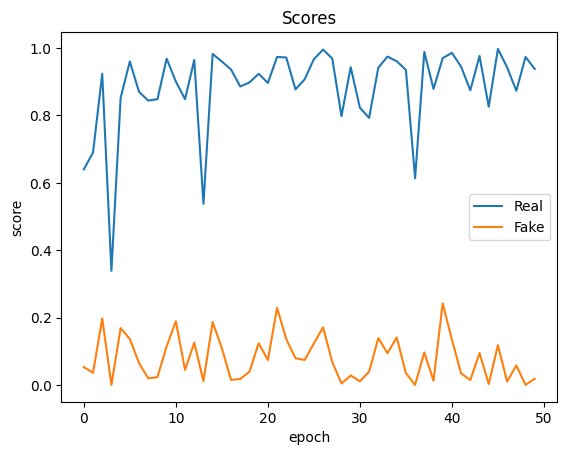

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [40]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gv3.pth')
torch.save(discriminator.state_dict(), 'Dv3.pth')

In [34]:
import cv2
import os

vid_fname = 'gans_training_v3.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [35]:
from IPython.display import Image

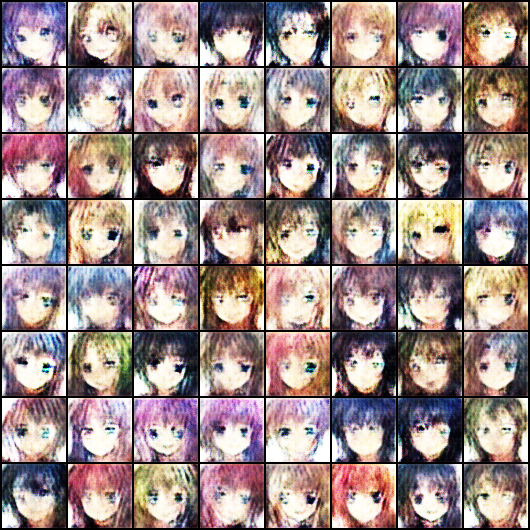

In [36]:
Image('./generated/generated-images-0001.png')

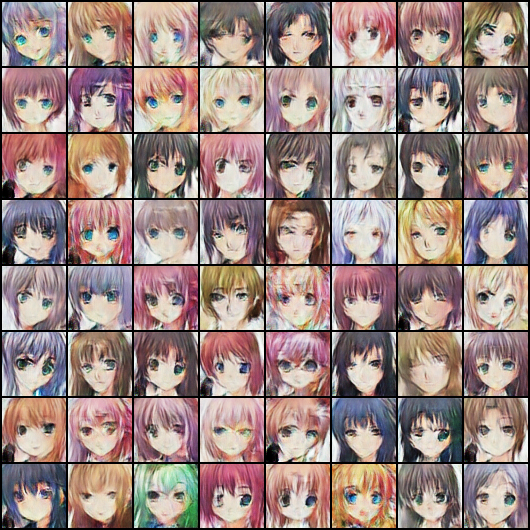

In [37]:
Image('./generated/generated-images-0010.png')

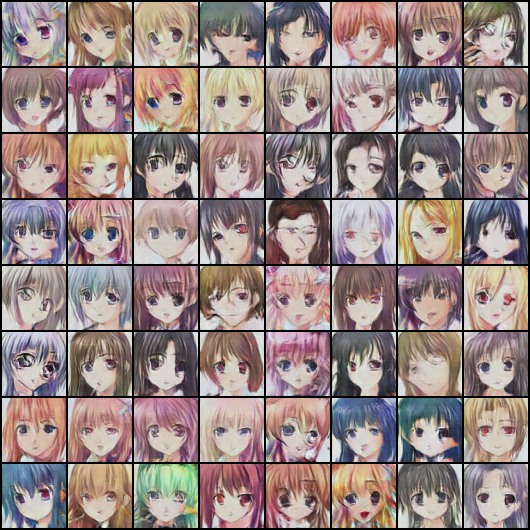

In [38]:
Image('./generated/generated-images-0025.png')

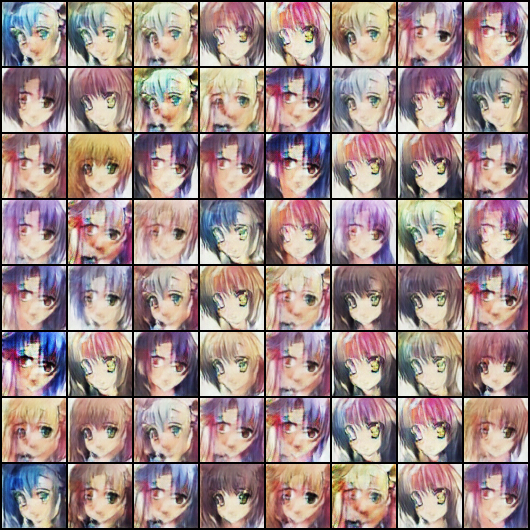

In [39]:
Image('./generated/generated-images-0050.png')

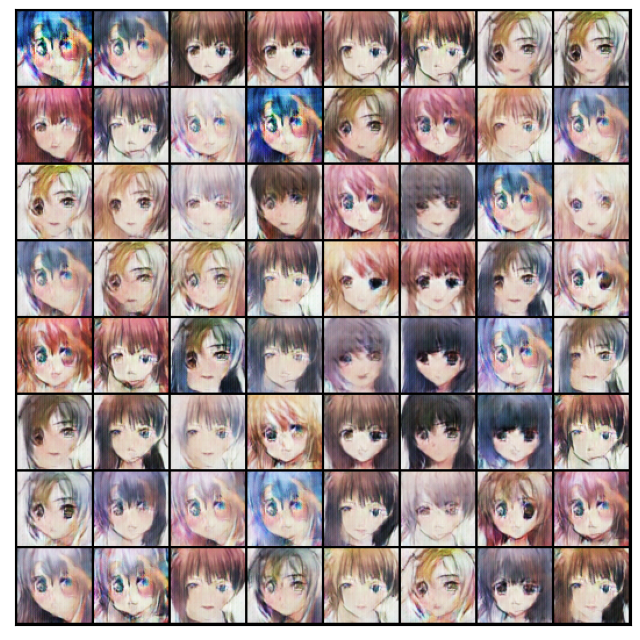

In [48]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))